In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
import hdbscan

/home/jhummel/anaconda/lib/python3.5/site-packages/IPython/html.py:14: ShimWarning: The `IPython.html` package has been deprecated. You should import from `notebook` instead. `IPython.html.widgets` has moved to `ipywidgets`.
  "`IPython.html.widgets` has moved to `ipywidgets`.", ShimWarning)


In [2]:
pd.set_option("display.max_rows",2000)
pd.set_option("display.max_columns",100)
pd.set_option('max_colwidth', 100)

Load Data

In [3]:
df_data = pd.read_csv('college-scorecard-raw-data-030216/merged_2013_PP.csv', encoding='iso-8859-1',
                      na_values="PrivacySuppressed")
df_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7804 entries, 0 to 7803
Columns: 1729 entries, UNITID to C200_4_POOLED_SUPP
dtypes: float64(1710), int64(12), object(7)
memory usage: 102.9+ MB


/home/jhummel/anaconda/lib/python3.5/site-packages/IPython/core/interactiveshell.py:2717: DtypeWarning: Columns (9) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


Select out numerical data columns, interpolate NaNs using column mean, and drop all-NaN columns

In [4]:
g = df_data.columns.to_series().groupby(df_data.dtypes).groups
col_types = {k.name: v for k, v in g.items()}
col_types.keys()
#df = df.drop(col_types['object'], axis=1)
nostr = df_data.drop(col_types['object'], axis=1)
numerical = nostr.fillna(nostr.mean(), inplace=True)
numerical.dropna(axis=1, inplace=True)

Group variables by dev-category using the Data Dictionary.

In [5]:
df_dict = pd.read_csv('CollegeScorecardDataDictionary-09-08-2015.csv')
df_dict.set_index('VARIABLE NAME', inplace=True)
dcat = df_dict.groupby('dev-category')
dcat.groups.keys()

dict_keys(['root', 'school', 'completion', 'aid', 'earnings', 'academics', 'repayment', 'cost', 'admissions', 'student'])

Number of variables in each group

In [6]:
for key in dcat.groups.keys():
    print(key+': ',len(dcat.groups[key]))

root:  5
school:  165
completion:  1023
aid:  40
earnings:  73
academics:  228
repayment:  130
cost:  65
admissions:  25
student:  94


In [7]:
numerical.fillna(numerical.mean()).info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7804 entries, 0 to 7803
Columns: 543 entries, UNITID to C200_4_POOLED_SUPP
dtypes: float64(531), int64(12)
memory usage: 32.3 MB


# Correlations

Pairwise correlations with missing data

In [8]:
icorr_nan = df_data.corr()

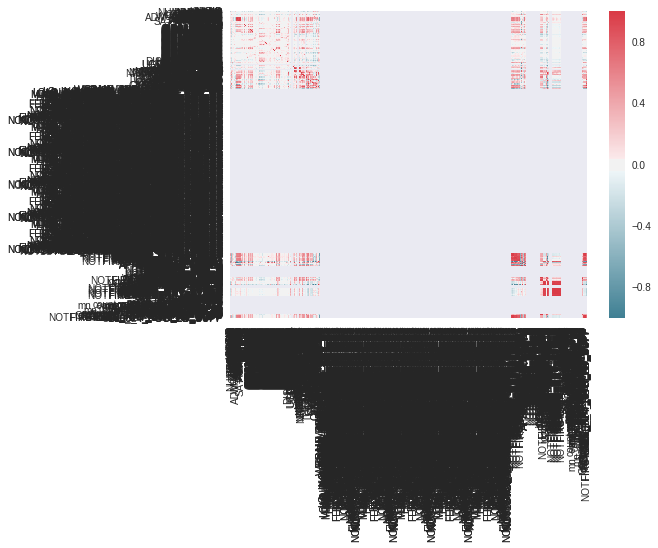

In [9]:
sns.heatmap(icorr_nan, cmap=sns.diverging_palette(220, 10, as_cmap=True), vmax=.5)

Pairwise correlations with missing data interpolated

In [10]:
icorr_num = numerical.corr()

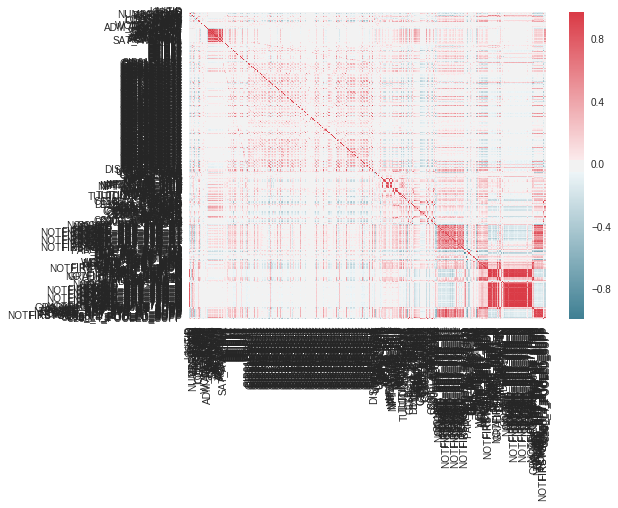

In [11]:
sns.heatmap(icorr_num, cmap=sns.diverging_palette(220, 10, as_cmap=True), vmax=.5)

### Variable correlation with 6-year completion rate

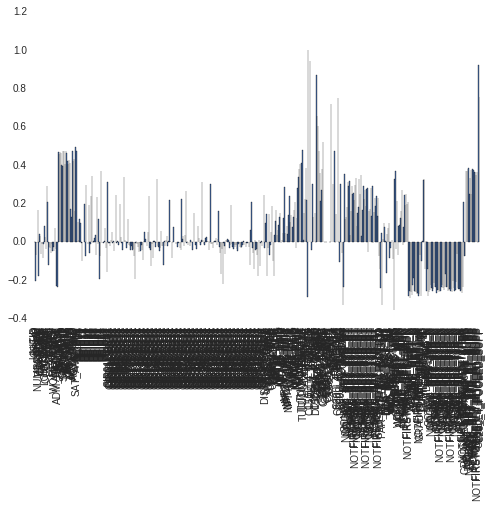

In [12]:
comp_corr_num = icorr_num['C150_4']
comp_corr_num.plot(kind='bar')

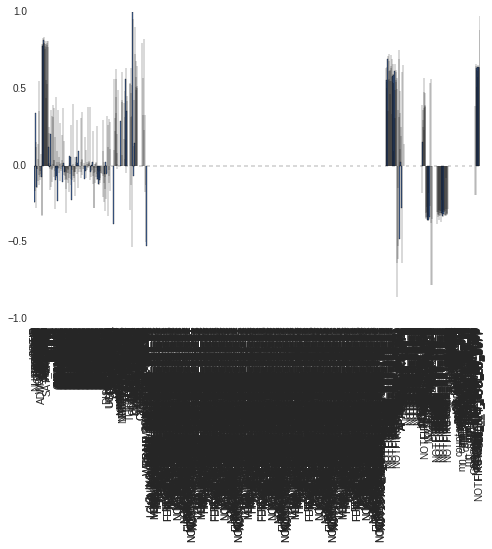

In [13]:
comp_corr_nan = icorr_nan['C150_4']
comp_corr_nan.plot(kind='bar')

In [14]:
strong_corr = comp_corr_nan[np.abs(comp_corr_nan) > .5]
strong_corr.sort_values()

DEP_STAT_PCT_IND              -0.853867
DEP_STAT_N                    -0.781335
INC_N                         -0.781335
INC_PCT_LO                    -0.634918
PAR_ED_PCT_HS                 -0.632045
PAR_ED_PCT_1STGEN             -0.607640
PCTPELL                       -0.533089
DEP_INC_PCT_LO                -0.524517
CDR3                          -0.524430
UG25abv                       -0.500529
C150_4_2MOR                    0.508219
NONCOM_RPY_3YR_RT              0.508860
C150_4_NHPI                    0.513082
COMPL_RPY_3YR_RT_SUPP          0.513918
C150_4_NRA                     0.518893
AVGFACSAL                      0.523183
TUITIONFEE_IN                  0.533801
ACTWRMID                       0.534349
NONCOM_RPY_7YR_RT              0.537750
COSTT4_A                       0.538260
CUML_DEBT_P25                  0.539124
LO_INC_RPY_7YR_RT              0.540747
LO_INC_RPY_3YR_RT              0.541578
FIRSTGEN_RPY_5YR_RT            0.544705
PELL_RPY_7YR_RT                0.545967


In [29]:
df_dict.reset_index(inplace=True)
df_dict.columns

Index(['index', 'VARIABLE NAME', 'NAME OF DATA ELEMENT', 'dev-category',
       'developer-friendly name', 'API data type', 'VALUE', 'LABEL', 'SOURCE',
       'NOTES'],
      dtype='object')

In [33]:
strong_corr.keys().values

array(['CCUGPROF', 'SATVR25', 'SATVR75', 'SATMT25', 'SATMT75', 'SATWR25',
       'SATWR75', 'SATVRMID', 'SATMTMID', 'SATWRMID', 'ACTCM25', 'ACTCM75',
       'ACTEN25', 'ACTEN75', 'ACTMT25', 'ACTMT75', 'ACTWR25', 'ACTCMMID',
       'ACTENMID', 'ACTMTMID', 'ACTWRMID', 'SAT_AVG', 'SAT_AVG_ALL',
       'NPT4_PUB', 'NPT44_PUB', 'NPT45_PUB', 'NPT4_75UP_PUB', 'NUM44_PUB',
       'NUM45_PUB', 'COSTT4_A', 'TUITIONFEE_IN', 'TUITIONFEE_OUT',
       'AVGFACSAL', 'PCTPELL', 'C150_4', 'C150_4_POOLED', 'C150_4_WHITE',
       'C150_4_BLACK', 'C150_4_HISP', 'C150_4_ASIAN', 'C150_4_NHPI',
       'C150_4_2MOR', 'C150_4_NRA', 'C150_4_UNKN', 'C200_4', 'RET_FT4',
       'C200_4_POOLED', 'UG25abv', 'CDR3', 'RPY_3YR_RT',
       'COMPL_RPY_3YR_RT', 'NONCOM_RPY_3YR_RT', 'LO_INC_RPY_3YR_RT',
       'MD_INC_RPY_3YR_RT', 'HI_INC_RPY_3YR_RT', 'DEP_RPY_3YR_RT',
       'PELL_RPY_3YR_RT', 'NOPELL_RPY_3YR_RT', 'FEMALE_RPY_3YR_RT',
       'MALE_RPY_3YR_RT', 'FIRSTGEN_RPY_3YR_RT', 'NOTFIRSTGEN_RPY_3YR_RT',
       'RPY_5Y

In [34]:
df_dict[df_dict['VARIABLE NAME'].isin(strong_corr.keys())]

,index,VARIABLE NAME,NAME OF DATA ELEMENT,dev-category,developer-friendly name,API data type,VALUE,LABEL,SOURCE,NOTES
151,151,CCUGPROF,Carnegie Classification -- undergraduate profile,school,carnegie_undergrad,integer,1,Higher part-time two-year (associate’s degree-granting institutions with at least 60 percent of ...,IPEDS,NaN
268,268,SATVR25,25th percentile of SAT scores at the institution (critical reading),admissions,sat_scores.25th_percentile.critical_reading,float,NaN,NaN,IPEDS,NaN
269,269,SATVR75,75th percentile of SAT scores at the institution (critical reading),admissions,sat_scores.75th_percentile.critical_reading,float,NaN,NaN,IPEDS,NaN
270,270,SATMT25,25th percentile of SAT scores at the institution (math),admissions,sat_scores.25th_percentile.math,float,NaN,NaN,IPEDS,NaN
271,271,SATMT75,75th percentile of SAT scores at the institution (math),admissions,sat_scores.75th_percentile.math,float,NaN,NaN,IPEDS,NaN
272,272,SATWR25,25th percentile of SAT scores at the institution (writing),admissions,sat_scores.25th_percentile.writing,float,NaN,NaN,IPEDS,NaN
273,273,SATWR75,75th percentile of SAT scores at the institution (writing),admissions,sat_scores.75th_percentile.writing,float,NaN,NaN,IPEDS,NaN
274,274,SATVRMID,Midpoint of SAT scores at the institution (critical reading),admissions,sat_scores.midpoint.critical_reading,float,NaN,NaN,IPEDS,NaN
275,275,SATMTMID,Midpoint of SAT scores at the institution (math),admissions,sat_scores.midpoint.math,float,NaN,NaN,IPEDS,NaN
276,276,SATWRMID,Midpoint of SAT scores at the institution (writing),admissions,sat_scores.midpoint.writing,float,NaN,NaN,IPEDS,NaN


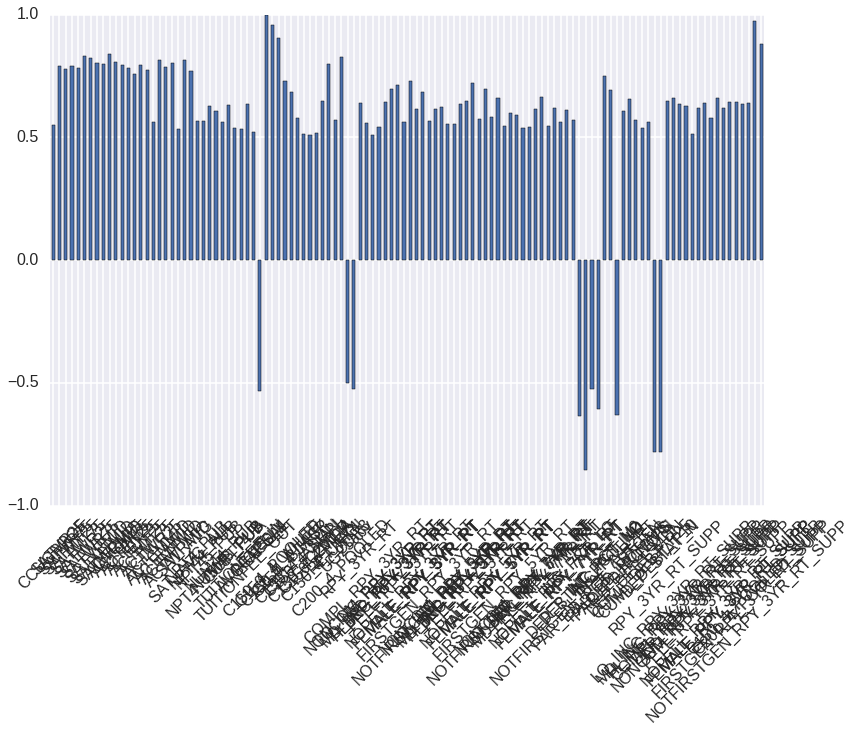

In [15]:
with sns.plotting_context('poster'):
    strong_corr.plot(kind='bar', rot=45)

In [16]:
strong_corr.keys()

Index(['CCUGPROF', 'SATVR25', 'SATVR75', 'SATMT25', 'SATMT75', 'SATWR25',
       'SATWR75', 'SATVRMID', 'SATMTMID', 'SATWRMID',
       ...
       'DEP_RPY_3YR_RT_SUPP', 'IND_RPY_3YR_RT_SUPP', 'PELL_RPY_3YR_RT_SUPP',
       'NOPELL_RPY_3YR_RT_SUPP', 'FEMALE_RPY_3YR_RT_SUPP',
       'MALE_RPY_3YR_RT_SUPP', 'FIRSTGEN_RPY_3YR_RT_SUPP',
       'NOTFIRSTGEN_RPY_3YR_RT_SUPP', 'C150_4_POOLED_SUPP',
       'C200_4_POOLED_SUPP'],
      dtype='object', length=114)

# Clustering

In [17]:
clusterer = hdbscan.HDBSCAN()

In [18]:
clusterer.fit(numerical)

clusterer.labels_.max(), clusterer.labels_.min()

(124, -1)

In [19]:
print(np.where(clusterer.labels_ == -1)[0].size)

870


In [20]:
print(np.where(clusterer.labels_ != -1)[0].size)

6934


In [21]:
print(clusterer.probabilities_.max(), clusterer.probabilities_[np.where(clusterer.labels_ != -1)[0]].min())

1.0 7.67651437468e-06
